# Approximate Sparse Filtrations

In this module, we will explore an approximation algorithm which is meant to reduce the run time of the persistence algorithm [1].  For more information on this algorithm, please view the following video:

https://www.youtube.com/watch?v=3WxuSwQhAgU


[1] Cavanna, Nicholas J., Mahmoodreza Jahanseir, and Donald R. Sheehy. "<a href = "https://arxiv.org/pdf/1506.03797.pdf">A geometric perspective on sparse filtrations</a>." Proceedings of the Canadian Conference on Computational Geometry (CCCG 2015).

In [1]:
from ripser import ripser
from persim import plot_diagrams
import tadasets

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from scipy import sparse
import time

Now, we define a "greedy permutation," as a function which performs furthest points sampling, a key step in the algorithm used to determine "insertion radii" $\lambda_i$ for each point.  For an animation of how this works, please visit: 

https://gist.github.com/ctralie/128cc07da67f1d2e10ea470ee2d23fe8

In [2]:
def getGreedyPerm(D):
    """
    A Naive O(N^2) algorithm to do furthest points sampling
    
    Parameters
    ----------
    D : ndarray (N, N) 
        An NxN distance matrix for points

    Return
    ------
    lamdas: list
        Insertion radii of all points
    """
    
    N = D.shape[0]
    #By default, takes the first point in the permutation to be the
    #first point in the point cloud, but could be random
    perm = np.zeros(N, dtype=np.int64)
    lambdas = np.zeros(N)
    ds = D[0, :]
    for i in range(1, N):
        idx = np.argmax(ds)
        perm[i] = idx
        lambdas[i] = ds[idx]
        ds = np.minimum(ds, D[idx, :])
    return lambdas[perm]

Now, we define a function which, given a distance matrix representing a point cloud, a set of insertion radii, and an approximation factor $\epsilon$, returns a sparse distance matrix with re-weighted edges, whose persistence diagrams are each guaranteed to be a $(1+\epsilon)$ multiplicative approximation of the true persistence diagrams (see [1])

In [3]:
def getApproxSparseDM(lambdas, eps, D):
    """
    Purpose: To return the sparse edge list with the warped distances, sorted by weight
    
    Parameters
    ----------
    lambdas: list
        insertion radii for points
    eps: float
        epsilon approximation constant
    D: ndarray
        NxN distance matrix, okay to modify because last time it's used
    
    Return
    ------
    DSparse: scipy.sparse
        A sparse NxN matrix with the reweighted edges
    """
    N = D.shape[0]
    E0 = (1+eps)/eps
    E1 = (1+eps)**2/eps
    
    # Create initial sparse list candidates (Lemma 6)
    # Search neighborhoods 
    nBounds = ((eps**2+3*eps+2)/eps)*lambdas 
    
    # Set all distances outside of search neighborhood to infinity
    D[D > nBounds[:, None]] = np.inf 
    [I, J] = np.meshgrid(np.arange(N), np.arange(N))
    idx = I < J
    I = I[(D < np.inf)*(idx == 1)]
    J = J[(D < np.inf)*(idx == 1)]
    D = D[(D < np.inf)*(idx == 1)]
    
    #Prune sparse list and update warped edge lengths (Algorithm 3 pg. 14)
    minlam = np.minimum(lambdas[I], lambdas[J])
    maxlam = np.maximum(lambdas[I], lambdas[J])
    
    # Rule out edges between vertices whose balls stop growing before they touch
    # or where one of them would have been deleted.  M stores which of these
    # happens first
    M = np.minimum((E0 + E1)*minlam, E0*(minlam + maxlam))
    
    t = np.arange(len(I))
    t = t[D <= M]
    (I, J, D) = (I[t], J[t], D[t])
    minlam = minlam[t]
    maxlam = maxlam[t]
    
    # Now figure out the metric of the edges that are actually added
    t = np.ones(len(I))
    
    # If cones haven't turned into cylinders, metric is unchanged
    t[D <= 2*minlam*E0] = 0 

    # Otherwise, if they meet before the M condition above, the metric is warped
    D[t == 1] = 2.0*(D[t == 1] - minlam[t == 1]*E0) # Multiply by 2 convention
    return sparse.coo_matrix((D, (I, J)), shape=(N, N)).tocsr()

Now let's set up a point cloud we can test this on, which has enough points for ripser to start slowing down a bit.  We'll perform the full rips filtration on this point cloud as a ground truth, and we will time it

Elapsed Time: 19.2 seconds, 1999000 Edges added


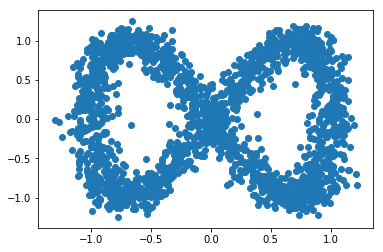

In [7]:
X = tadasets.infty_sign(n=2000, noise=0.1)
plt.scatter(X[:, 0], X[:, 1])

tic = time.time()
resultfull = ripser(X)
toc = time.time()
timefull = toc-tic
print("Elapsed Time: %.3g seconds, %i Edges added"%(timefull, resultfull['num_edges']))

Now let's run an approximate version and plot $H_1$ for both next to each other

In [8]:
eps = 0.1

# Compute the sparse filtration
tic = time.time()

# First compute all pairwise distances and do furthest point sampling
D = pairwise_distances(X, metric='euclidean')
lambdas = getGreedyPerm(D)

# Now compute the sparse distance matrix
DSparse = getApproxSparseDM(lambdas, eps, D)

# Finally, compute the filtration
resultsparse = ripser(DSparse, distance_matrix=True)
toc = time.time()
timesparse = toc-tic
percent_added = 100.0*float(resultsparse['num_edges'])/resultfull['num_edges']
print("Elapsed Time: %.3g seconds, %i Edges added"%(timesparse, resultsparse['num_edges']))

Elapsed Time: 1.24 seconds, 343678 Edges added


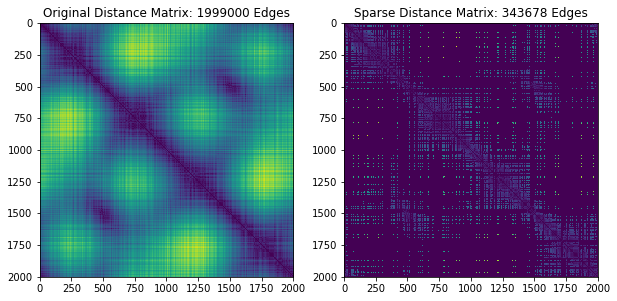

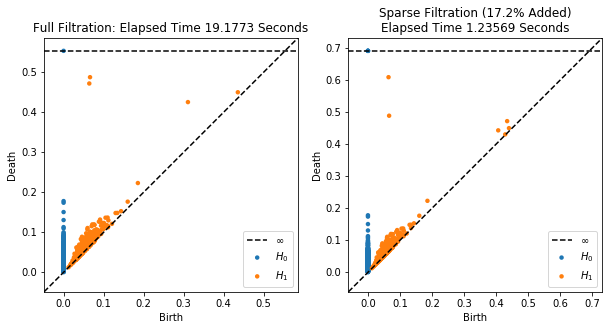

In [9]:
# Plot the sparse distance matrix and edges that were added
plt.figure(figsize=(10, 5))
plt.subplot(121)
D = pairwise_distances(X, metric='euclidean')
plt.imshow(D)
plt.title("Original Distance Matrix: %i Edges"%resultfull['num_edges'])
plt.subplot(122)
DSparse = DSparse.toarray()
DSparse = DSparse + DSparse.T
plt.imshow(DSparse)
plt.title("Sparse Distance Matrix: %i Edges"%resultsparse['num_edges'])

# And plot the persistence diagrams on top of each other
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_diagrams(resultfull['dgms'], show=False)
plt.title("Full Filtration: Elapsed Time %g Seconds"%timefull)
plt.subplot(122)
plt.title("Sparse Filtration (%.3g%% Added)\nElapsed Time %g Seconds"%(percent_added, timesparse))
plot_diagrams(resultsparse['dgms'], show=False)

Now we'll do the exact same thing, but this time we'll raise epsilon to get a faster, slightly worse approximation

In [10]:
eps = 0.4

# Compute the sparse filtration
tic = time.time()

# First compute all pairwise distances and do furthest point sampling
D = pairwise_distances(X, metric='euclidean')
lambdas = getGreedyPerm(D)

# Now compute the sparse distance matrix
DSparse = getApproxSparseDM(lambdas, eps, D)

# Finally, compute the filtration
resultsparse = ripser(DSparse, distance_matrix=True)
toc = time.time()
timesparse = toc-tic
percent_added = 100.0*float(resultsparse['num_edges'])/resultfull['num_edges']
print("Elapsed Time: %.3g seconds, %i Edges added"%(timesparse, resultsparse['num_edges']))

Elapsed Time: 0.322 seconds, 85034 Edges added


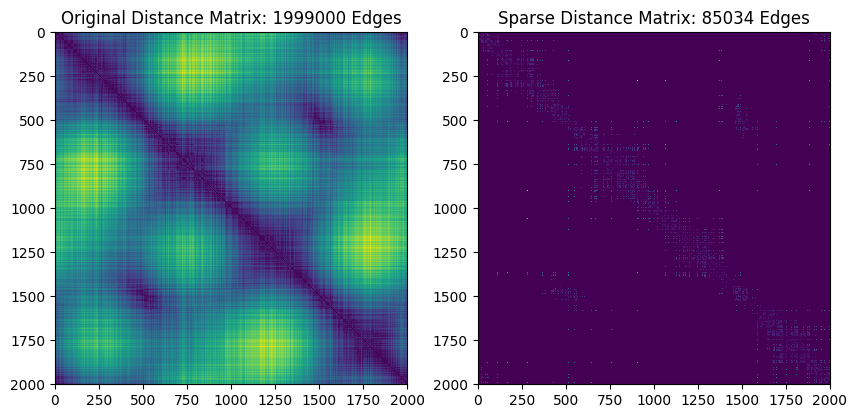

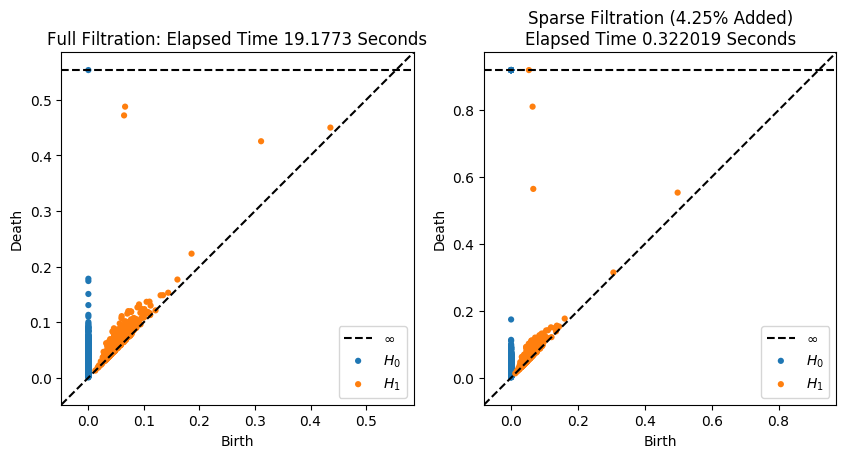

In [11]:
#Plot the sparse distance matrix and edges that were added
plt.figure(figsize=(10, 5))
plt.subplot(121)
D = pairwise_distances(X, metric='euclidean')
plt.imshow(D)
plt.title("Original Distance Matrix: %i Edges"%resultfull['num_edges'])
plt.subplot(122)
DSparse = DSparse.toarray()
DSparse = DSparse + DSparse.T
plt.imshow(DSparse)
plt.title("Sparse Distance Matrix: %i Edges"%resultsparse['num_edges'])

#And plot the persistence diagrams on top of each other
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_diagrams(resultfull['dgms'], show=False)
plt.title("Full Filtration: Elapsed Time %g Seconds"%timefull)
plt.subplot(122)
plt.title("Sparse Filtration (%.3g%% Added)\nElapsed Time %g Seconds"%(percent_added, timesparse))
plot_diagrams(resultsparse['dgms'], show=False)

Not bad for nearly two orders of magnitude faster!  Mainly, the death times just got a little bit later for the two most important classes in $H_1$